<a href="https://colab.research.google.com/github/DasBytes/three-stage-banglish-depression-classifier/blob/main/Banglish_Depression_classifier_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import shutil
import os

# Define the target path where the model script will look for the file
TARGET_FILE_PATH = 'Banglish depression dataset.csv'

# ==========================================
# STEP 1: UPLOAD & SAVE DATA
# ==========================================
print("--- FILE UPLOAD SCRIPT (Run this first) ---")
print("Please use the 'Choose Files' button to select your 'Banglish depression dataset.csv' file.")
print(f"The file will be saved locally as '{TARGET_FILE_PATH}' for the model script to use.")

try:
    # Open Upload Dialog
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded!"); raise ValueError("No file uploaded")

    # Get the name of the file uploaded by the user
    original_file_name = list(uploaded.keys())[0]

    # Save the file content to the fixed target path
    with open(TARGET_FILE_PATH, 'wb') as f:
        f.write(uploaded[original_file_name])

    print(f"\nSUCCESS! File saved to disk at: {TARGET_FILE_PATH}")
    print("\n--- Next, run the 'regression_script.py' code block to load and train the model. ---")

except Exception as e:
    print(f"\nERROR during upload: {e}")

--- FILE UPLOAD SCRIPT (Run this first) ---
Please use the 'Choose Files' button to select your 'Banglish depression dataset.csv' file.
The file will be saved locally as 'Banglish depression dataset.csv' for the model script to use.


Saving Banglish depression dataset.csv to Banglish depression dataset.csv

SUCCESS! File saved to disk at: Banglish depression dataset.csv

--- Next, run the 'regression_script.py' code block to load and train the model. ---


#Logistic Regression



 STEP 1: DATA LOADING
Found 'Banglish depression dataset.csv'. Loading...
File Loaded. Original Rows: 6002
Classes Found: ['No Depression' 'Mild' 'Severe']
Injecting Context Examples...
Training Data Prepared. Total Rows: 6011

Step 2: Preprocessing Text...

Step 3: Training Logistic Regression with N-Grams...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Step 4: Evaluating Performance...
Final Accuracy: 86.62%

Classification Report:
               precision    recall  f1-score   support

         Mild       0.81      0.78      0.80       400
No Depression       0.80      0.84      0.82       402
       Severe       0.99      0.97      0.98       401

     accuracy                           0.87      1203
    macro avg       0.87      0.87      0.87      1203
 weighted avg       0.87      0.87      0.87      1203



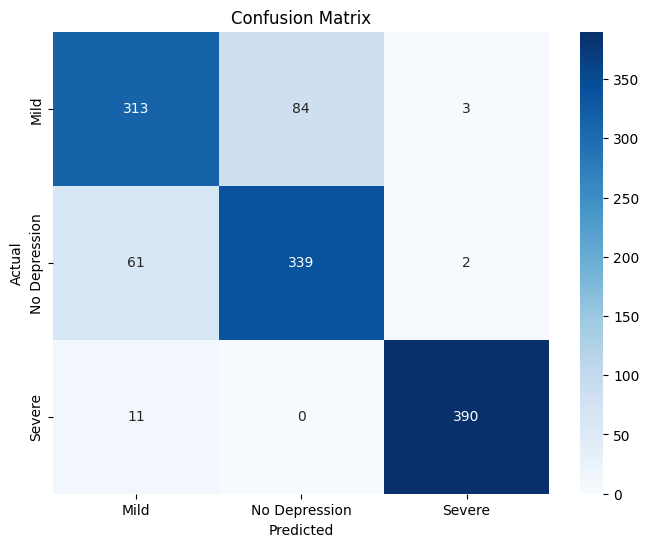


 LIVE PREDICTION SYSTEM 
Type a Banglish sentence below

Enter Text: sobai kemon acho
Prediction: [No Depression] | Confidence: 97.18%

Enter Text: ajke beshi ghum pacche
Prediction: [No Depression] | Confidence: 72.68%

Enter Text: ami ajkei more jabo
Prediction: [Severe] | Confidence: 63.82%

Enter Text: amar break hoyese, mon khub kharap
Prediction: [Mild] | Confidence: 96.47%

Exiting...


In [ ]:
# ==============================================================================
# Project: Three-Level Depression Classification (Banglish)
# Model: Logistic Regression (Context-Aware via N-Grams)
# System: Load -> Clean -> Teach Context -> Train -> Live Predict
# ==============================================================================

import pandas as pd
import numpy as np
import re
import string
import os
import matplotlib.pyplot as plt
import seaborn as sns

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# NLP Libraries
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# ==========================================
# STEP 1: LOAD DATA
# ==========================================
print("\n" + "="*50)
print(" STEP 1: DATA LOADING")
print("="*50)

FILENAME = 'Banglish depression dataset.csv'

if not os.path.exists(FILENAME):
    print(f"ERROR: File '{FILENAME}' not found in the current directory.")
    print("Please upload the file to the Colab 'Files' tab on the left.")
    raise FileNotFoundError(f"File '{FILENAME}' not found.")

print(f"Found '{FILENAME}'. Loading...")

try:
    # Read file
    df = pd.read_csv(FILENAME)

    # Handle header issues
    if 'Category' not in df.columns:
        df = pd.read_csv(FILENAME, skiprows=2)

    # Drop empty rows
    df.dropna(subset=['Sentence', 'Category'], inplace=True)

    # Simple whitespace clean (No label replacement)
    df['Category'] = df['Category'].str.strip()

    print(f"File Loaded. Original Rows: {len(df)}")
    print("Classes Found:", df['Category'].unique())

    # ==========================================
    # STEP 2: CONTEXT TEACHING (AUGMENTATION)
    # ==========================================
    # Adds specific examples to help the model understand neutral vs severe context
    print("Injecting Context Examples...")

    teaching_data = [
        # Neutral Context (Daily activities)
        {'Sentence': 'ami ajke bajare jabo', 'Category': 'No Depression'},
        {'Sentence': 'ami office e jabo', 'Category': 'No Depression'},
        {'Sentence': 'ajke weather ta nice', 'Category': 'No Depression'},

        # Positive Context
        {'Sentence': 'ami valo achi', 'Category': 'No Depression'},
        {'Sentence': 'shobai kemon acho', 'Category': 'No Depression'},
        {'Sentence': 'alhamdulillah bhalo achi', 'Category': 'No Depression'},

        # Severe Context
        {'Sentence': 'ami suicide korbo', 'Category': 'Severe'},
        {'Sentence': 'ami ar bachbo na', 'Category': 'Severe'},
        {'Sentence': 'goodbye earth', 'Category': 'Severe'}
    ]

    df = pd.concat([df, pd.DataFrame(teaching_data)], ignore_index=True)
    print(f"Training Data Prepared. Total Rows: {len(df)}")

except Exception as e:
    print(f"\nCRITICAL ERROR: {e}")
    raise

# ==========================================
# STEP 3: PREPROCESSING
# ==========================================
print("\nStep 2: Preprocessing Text...")

def preprocess(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    return text

df['Cleaned'] = df['Sentence'].apply(preprocess)

# Split Data
X = df['Cleaned']
y = df['Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ==========================================
# STEP 4: TRAINING (CONTEXT AWARE)
# ==========================================
print("\nStep 3: Training Logistic Regression with N-Grams...")

# N-Grams (1, 3) allows model to see "valo achi" vs "valo na"
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))

X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

# High C value forces model to pay attention to teaching examples
model = LogisticRegression(max_iter=1000, multi_class='multinomial', C=10.0)
model.fit(X_train_vec, y_train)

# ==========================================
# STEP 5: EVALUATION
# ==========================================
print("\nStep 4: Evaluating Performance...")
y_pred = model.predict(X_test_vec)
acc = accuracy_score(y_test, y_pred)
print(f"Final Accuracy: {acc*100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
try:
    plt.figure(figsize=(8,6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
except: pass

# ==========================================
# STEP 6: LIVE PREDICTION BOX
# ==========================================
print("\n" + "="*50)
print(" LIVE PREDICTION SYSTEM ")
print("="*50)
print("Type a Banglish sentence below")

while True:
    try:
        txt = input("\nEnter Text: ")
        if txt.lower() in ['exit', 'quit']:
            print("Exiting...")
            break
        if not txt.strip(): continue

        clean_txt = preprocess(txt)
        vec = tfidf.transform([clean_txt])

        pred = model.predict(vec)[0]
        prob = np.max(model.predict_proba(vec)) * 100

        print(f"Prediction: [{pred}] | Confidence: {prob:.2f}%")

    except KeyboardInterrupt:
        print("\nExiting...")
        break

#support Vector Machine (SVM)
